In [1]:
# Load data and run the energy computation chain
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

from src.energy import compute_daily_energy

# Raw upstream data
pv_raw = pd.read_csv(ROOT / 'data/energy/daily_pv_output-research.csv', comment='#', parse_dates=['date'])
wind_raw = pd.read_csv(ROOT / 'data/energy/daily_wind_output-research.csv', comment='#', parse_dates=['date'])
weather = pd.read_csv(ROOT / 'data/weather/daily_weather_openfield-research.csv', comment='#', parse_dates=['date'])

# Scaled community output (with agri-PV farms)
energy = compute_daily_energy(
    config_path=ROOT / 'settings/energy_system.yaml',
    registry_path=ROOT / 'settings/data_registry.yaml',
    farm_profiles_path=ROOT / 'settings/farm_profiles.yaml',
)

print(f'Weather rows: {len(weather)}, PV rows: {len(pv_raw)}, Wind rows: {len(wind_raw)}')
print(f'Energy output rows: {len(energy)}')
print(f'Date range: {pv_raw.date.min().date()} to {pv_raw.date.max().date()}')
print(f'\nEnergy output columns: {list(energy.columns)}')

Weather rows: 5479, PV rows: 5479, Wind rows: 5479
Energy output rows: 5479
Date range: 2010-01-01 to 2024-12-31

Energy output columns: ['day', 'farm_1_agripv_kwh', 'farm_2_agripv_kwh', 'low_density_comm_solar_kwh', 'medium_density_comm_solar_kwh', 'high_density_comm_solar_kwh', 'small_turbine_wind_kwh', 'medium_turbine_wind_kwh', 'large_turbine_wind_kwh', 'total_solar_kwh', 'total_wind_kwh', 'total_energy_kwh']


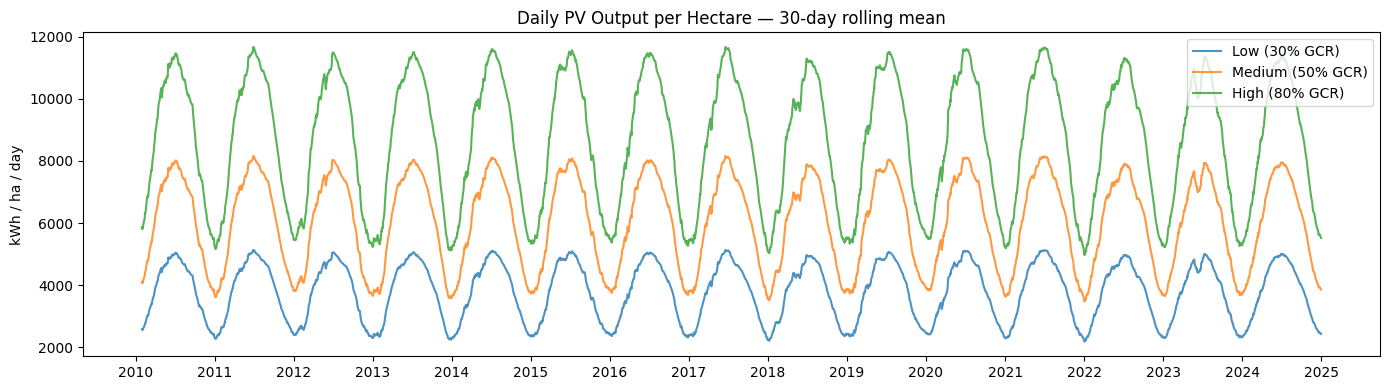

In [2]:
# 1. PV seasonal pattern — 30-day rolling average by density
fig, ax = plt.subplots(figsize=(14, 4))
for col, label in [('low_density_kwh_per_ha', 'Low (30% GCR)'),
                    ('medium_density_kwh_per_ha', 'Medium (50% GCR)'),
                    ('high_density_kwh_per_ha', 'High (80% GCR)')]:
    ax.plot(pv_raw['date'], pv_raw[col].rolling(30).mean(), label=label, alpha=0.8)
ax.set_ylabel('kWh / ha / day')
ax.set_title('Daily PV Output per Hectare — 30-day rolling mean')
ax.legend()
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.tight_layout()
plt.show()

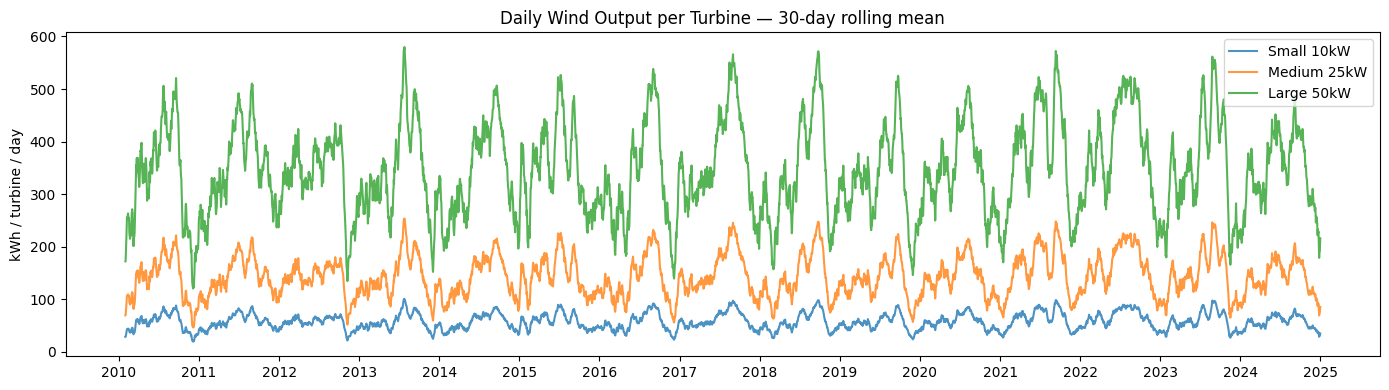

In [3]:
# 2. Wind seasonal pattern — 30-day rolling average by turbine size
fig, ax = plt.subplots(figsize=(14, 4))
for col, label in [('small_turbine_kwh', 'Small 10kW'),
                    ('medium_turbine_kwh', 'Medium 25kW'),
                    ('large_turbine_kwh', 'Large 50kW')]:
    ax.plot(wind_raw['date'], wind_raw[col].rolling(30).mean(), label=label, alpha=0.8)
ax.set_ylabel('kWh / turbine / day')
ax.set_title('Daily Wind Output per Turbine — 30-day rolling mean')
ax.legend()
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.tight_layout()
plt.show()

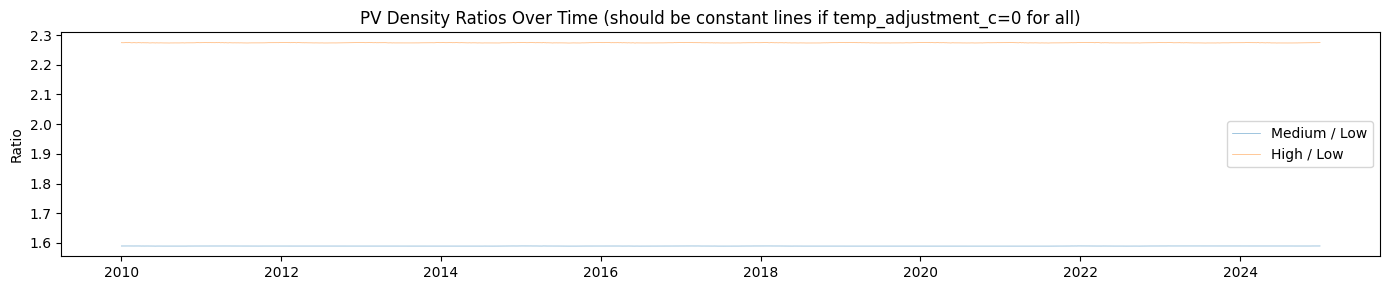

Medium/Low — mean: 1.589524, std: 1.19e-04
High/Low  — mean: 2.273890, std: 4.00e-04


In [4]:
# 3. PV density ratios — should be CONSTANT if temp_adjustment_c=0 for all densities
"""If ratios are perfectly flat, the 3 density levels carry zero independent
information — they are just rescaled copies of the same signal."""
ratio_ml = pv_raw['medium_density_kwh_per_ha'] / pv_raw['low_density_kwh_per_ha']
ratio_hl = pv_raw['high_density_kwh_per_ha'] / pv_raw['low_density_kwh_per_ha']

fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(pv_raw['date'], ratio_ml, label='Medium / Low', alpha=0.6, lw=0.5)
ax.plot(pv_raw['date'], ratio_hl, label='High / Low', alpha=0.6, lw=0.5)
ax.set_ylabel('Ratio')
ax.set_title('PV Density Ratios Over Time (should be constant lines if temp_adjustment_c=0 for all)')
ax.legend()
fig.tight_layout()
plt.show()

print(f'Medium/Low — mean: {ratio_ml.mean():.6f}, std: {ratio_ml.std():.2e}')
print(f'High/Low  — mean: {ratio_hl.mean():.6f}, std: {ratio_hl.std():.2e}')

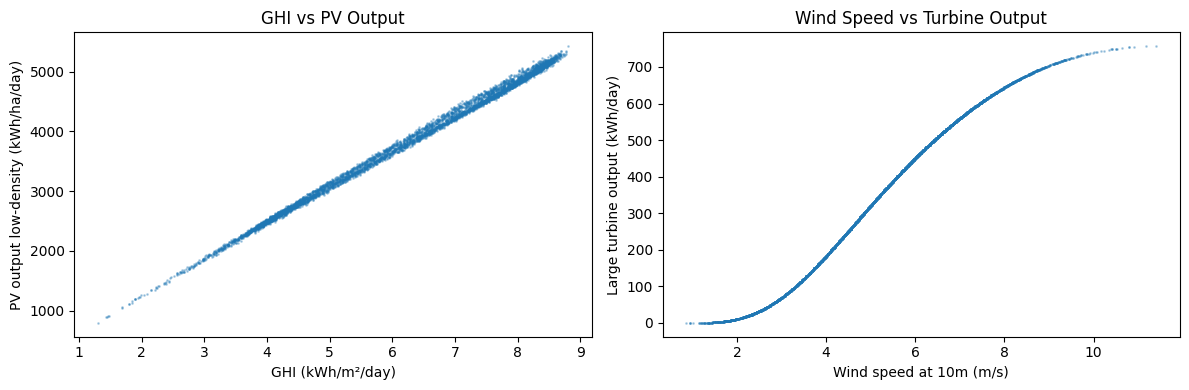

In [5]:
# 4. GHI vs PV output scatter — should be tightly linear
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.scatter(weather['solar_irradiance_kwh_m2'], pv_raw['low_density_kwh_per_ha'],
           s=1, alpha=0.3)
ax.set_xlabel('GHI (kWh/m²/day)')
ax.set_ylabel('PV output low-density (kWh/ha/day)')
ax.set_title('GHI vs PV Output')

ax = axes[1]
ax.scatter(weather['wind_speed_ms'], wind_raw['large_turbine_kwh'],
           s=1, alpha=0.3)
ax.set_xlabel('Wind speed at 10m (m/s)')
ax.set_ylabel('Large turbine output (kWh/day)')
ax.set_title('Wind Speed vs Turbine Output')

fig.tight_layout()
plt.show()

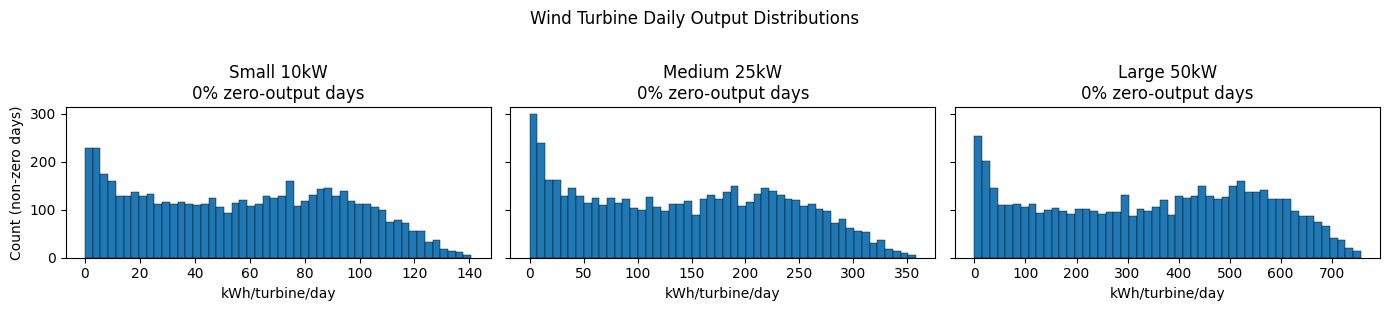

In [6]:
# 5. Wind output distribution — expect heavy right skew, many zeros for medium/large
fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharey=True)
for ax, (col, label) in zip(axes, [('small_turbine_kwh', 'Small 10kW'),
                                    ('medium_turbine_kwh', 'Medium 25kW'),
                                    ('large_turbine_kwh', 'Large 50kW')]):
    data = wind_raw[col]
    zero_pct = (data == 0).mean() * 100
    ax.hist(data[data > 0], bins=50, edgecolor='black', linewidth=0.3)
    ax.set_title(f'{label}\n{zero_pct:.0f}% zero-output days')
    ax.set_xlabel('kWh/turbine/day')
axes[0].set_ylabel('Count (non-zero days)')
fig.suptitle('Wind Turbine Daily Output Distributions', y=1.02)
fig.tight_layout()
plt.show()

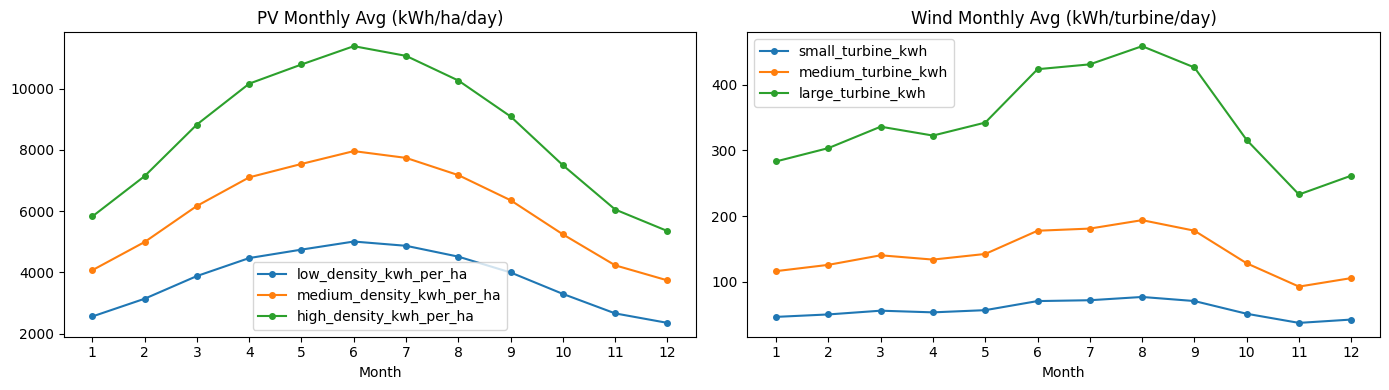

In [7]:
# 6. Monthly average energy — seasonal patterns for PV and wind
pv_monthly = pv_raw.set_index('date').resample('ME').mean(numeric_only=True)
wind_monthly = wind_raw.set_index('date').resample('ME').mean(numeric_only=True)

# Average by calendar month across all years
pv_by_month = pv_raw.copy()
pv_by_month['month'] = pv_by_month['date'].dt.month
pv_month_avg = pv_by_month.groupby('month')[['low_density_kwh_per_ha',
    'medium_density_kwh_per_ha', 'high_density_kwh_per_ha']].mean()

wind_by_month = wind_raw.copy()
wind_by_month['month'] = wind_by_month['date'].dt.month
wind_month_avg = wind_by_month.groupby('month')[['small_turbine_kwh',
    'medium_turbine_kwh', 'large_turbine_kwh']].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

pv_month_avg.plot(ax=axes[0], marker='o', markersize=4)
axes[0].set_title('PV Monthly Avg (kWh/ha/day)')
axes[0].set_xlabel('Month')
axes[0].set_xticks(range(1, 13))

wind_month_avg.plot(ax=axes[1], marker='o', markersize=4)
axes[1].set_title('Wind Monthly Avg (kWh/turbine/day)')
axes[1].set_xlabel('Month')
axes[1].set_xticks(range(1, 13))

fig.tight_layout()
plt.show()

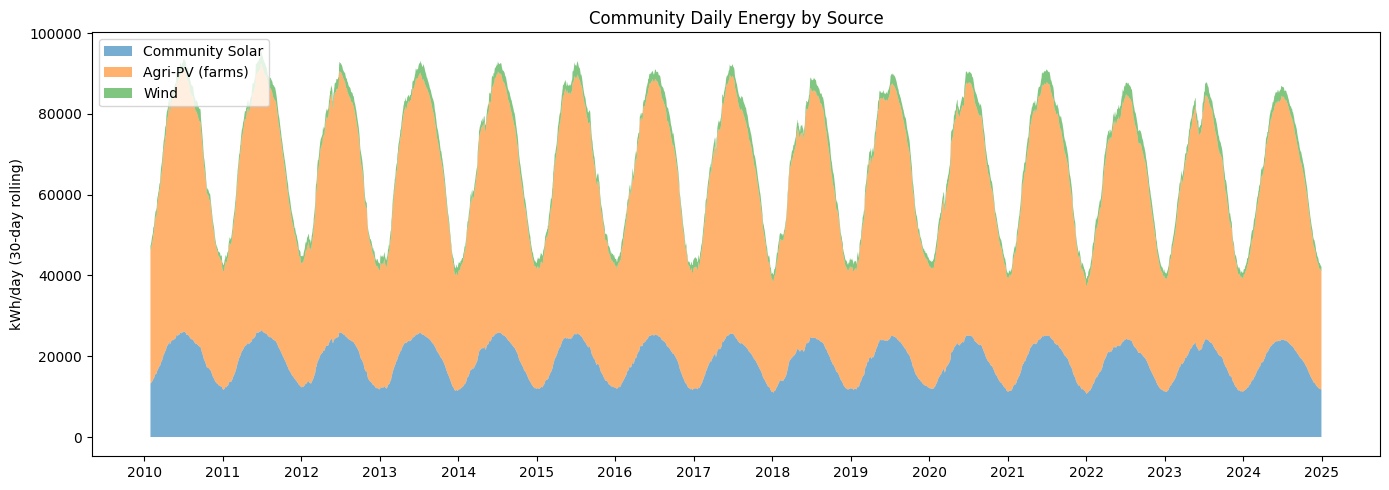

Annual mean total: 68453 kWh/day
  Solar share: 96.9%
  Wind share:  3.1%


In [8]:
# 7. Community-scaled total energy — stacked area by source
"""Config: community solar = 0.25ha low + 0.25ha med + 2ha high
         agri-PV = 5ha medium (farm_1) + 5ha low (farm_2)
         wind = 15 small + 4 medium + 2 large"""
fig, ax = plt.subplots(figsize=(14, 5))

solar_cols = [c for c in energy.columns if 'solar' in c and c != 'total_solar_kwh']
agripv_cols = [c for c in energy.columns if 'agripv' in c]
wind_cols = [c for c in energy.columns if 'wind' in c and c != 'total_wind_kwh']

rolling = 30
comm_solar = energy[[c for c in solar_cols if 'comm' in c]].sum(axis=1).rolling(rolling).mean()
agripv = energy[agripv_cols].sum(axis=1).rolling(rolling).mean() if agripv_cols else 0
wind_total = energy[wind_cols].sum(axis=1).rolling(rolling).mean()

ax.fill_between(energy['day'], 0, comm_solar, alpha=0.6, label='Community Solar')
ax.fill_between(energy['day'], comm_solar, comm_solar + agripv, alpha=0.6, label='Agri-PV (farms)')
ax.fill_between(energy['day'], comm_solar + agripv, comm_solar + agripv + wind_total,
                alpha=0.6, label='Wind')
ax.set_ylabel('kWh/day (30-day rolling)')
ax.set_title('Community Daily Energy by Source')
ax.legend(loc='upper left')
ax.xaxis.set_major_locator(mdates.YearLocator())
fig.tight_layout()
plt.show()

print(f'Annual mean total: {energy["total_energy_kwh"].mean():.0f} kWh/day')
print(f'  Solar share: {energy["total_solar_kwh"].mean() / energy["total_energy_kwh"].mean():.1%}')
print(f'  Wind share:  {energy["total_wind_kwh"].mean() / energy["total_energy_kwh"].mean():.1%}')

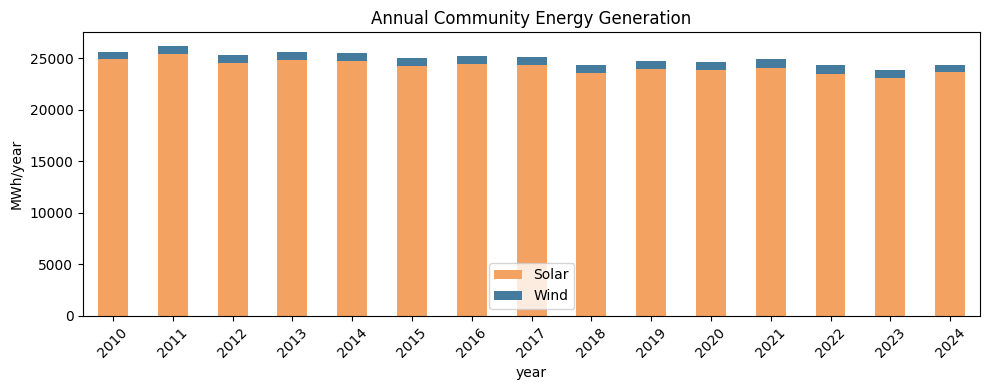

Year-over-year % change in total energy:
year
2011   +2.3%
2012   -3.4%
2013   +1.1%
2014   -0.2%
2015   -1.9%
2016   +0.5%
2017   -0.1%
2018   -3.2%
2019   +1.5%
2020   -0.3%
2021   +1.2%
2022   -2.3%
2023   -2.1%
2024   +2.2%


In [9]:
# 8. Annual totals by year — check for unexpected year-to-year drift
"""If panel degradation were modeled, expect ~0.5%/yr decline in PV.
Currently degradation is NOT applied — all years use year-0 efficiency."""
energy_annual = energy.copy()
energy_annual['year'] = energy_annual['day'].dt.year
annual = energy_annual.groupby('year')[['total_solar_kwh', 'total_wind_kwh', 'total_energy_kwh']].sum()
annual_mwh = annual / 1000

fig, ax = plt.subplots(figsize=(10, 4))
annual_mwh[['total_solar_kwh', 'total_wind_kwh']].plot(kind='bar', stacked=True, ax=ax,
    color=['#f4a261', '#457b9d'])
ax.set_ylabel('MWh/year')
ax.set_title('Annual Community Energy Generation')
ax.legend(['Solar', 'Wind'])
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
plt.show()

# Year-over-year % change to check for drift
yoy = annual['total_energy_kwh'].pct_change() * 100
print('Year-over-year % change in total energy:')
print(yoy.dropna().to_string(float_format='{:+.1f}%'.format))

In [10]:
# 9. Capacity factor check — compare model output to expected real-world values
"""Expected CFs: Solar in Sinai ~20-28% for TOPCon, Wind distributed ~15-25%.
Model PV CFs include temp derating, shading, and system losses.
Model wind CFs include Rayleigh correction and system losses."""
pv_specs = pd.read_csv(ROOT / 'data/energy/pv_systems-research.csv', comment='#')
wind_specs = pd.read_csv(ROOT / 'data/energy/wind_turbines-research.csv', comment='#')

print('=== PV Capacity Factors (model output) ===')
for _, pv in pv_specs.iterrows():
    col = f'{pv["density_name"]}_density_kwh_per_ha'
    panel_area = (pv['ground_coverage_pct'] / 100) * 10000  # m2/ha
    peak_kw = panel_area * pv['module_efficiency']  # kWp/ha at STC
    avg_kwh = pv_raw[col].mean()
    cf = avg_kwh / (peak_kw * 24) * 100
    print(f'  {pv["density_name"]:>6} density: CF = {cf:.1f}%  '
          f'(peak {peak_kw:.0f} kWp/ha, avg {avg_kwh:.0f} kWh/ha/day, '
          f'temp_adj +{pv["temp_adjustment_c"]}C)')

print()
print('=== Wind Capacity Factors (model vs spec) ===')
for _, t in wind_specs.iterrows():
    col = f'{t["turbine_name"]}_turbine_kwh'
    avg_kwh = wind_raw[col].mean()
    cf_model = avg_kwh / (t['rated_capacity_kw'] * 24) * 100
    cf_spec = t['capacity_factor_typical'] * 100
    print(f'  {t["turbine_name"]:>6} ({t["rated_capacity_kw"]:.0f}kW): '
          f'model CF = {cf_model:.1f}%, spec typical = {cf_spec:.0f}%, '
          f'losses = {t["system_losses_pct"]}%')

=== PV Capacity Factors (model output) ===
     low density: CF = 23.4%  (peak 675 kWp/ha, avg 3795 kWh/ha/day, temp_adj +7.0C)
  medium density: CF = 22.3%  (peak 1125 kWp/ha, avg 6032 kWh/ha/day, temp_adj +8.5C)
    high density: CF = 20.0%  (peak 1800 kWp/ha, avg 8629 kWh/ha/day, temp_adj +10.5C)

=== Wind Capacity Factors (model vs spec) ===
   small (10kW): model CF = 23.9%, spec typical = 18%, losses = 12%
  medium (25kW): model CF = 23.9%, spec typical = 25%, losses = 10%
   large (50kW): model CF = 28.7%, spec typical = 25%, losses = 10%


In [11]:
# 10. Cross-check: recompute one day manually and compare to pipeline output
"""Reads actual spec parameters to verify the generator + energy.py pipeline
produces consistent results end-to-end."""
sys.path.insert(0, str(ROOT / 'data' / '_scripts'))
from generate_energy_output import expected_wind_power_rayleigh, wind_speed_at_hub

row_idx = 3  # 2010-01-04 (a day with decent wind)
w = weather.iloc[row_idx]
pv_low = pv_specs[pv_specs['density_name'] == 'low'].iloc[0]
pv_med = pv_specs[pv_specs['density_name'] == 'medium'].iloc[0]
wt_small = wind_specs[wind_specs['turbine_name'] == 'small'].iloc[0]

print(f'Date: {w["date"].date()}')
print(f'Weather: GHI={w["solar_irradiance_kwh_m2"]}, wind={w["wind_speed_ms"]} m/s, '
      f'temp={w["temp_min_c"]}-{w["temp_max_c"]}C\n')

# Manual PV calc using actual spec params
ghi = w['solar_irradiance_kwh_m2']
t_avg = (w['temp_max_c'] + w['temp_min_c']) / 2
panel_area = (pv_low['ground_coverage_pct'] / 100) * 10000
t_cell = t_avg + pv_low['temp_adjustment_c']
temp_derate = 1 + pv_low['temp_coefficient_per_c'] * (t_cell - pv_low['temp_reference_c'])
pv_manual = (ghi * panel_area * pv_low['module_efficiency'] * pv_low['tilt_factor']
             * pv_low['irradiance_factor'] * temp_derate
             * (1 - pv_low['system_losses_pct'] / 100) * pv_low['shading_factor'])
pv_csv = pv_raw.iloc[row_idx]['low_density_kwh_per_ha']
print(f'PV low manual: {pv_manual:.2f}, CSV: {pv_csv:.2f}, match: {abs(pv_manual - pv_csv) < 0.1}')

# Manual wind calc using Rayleigh integration + system losses
v_hub = wind_speed_at_hub(np.array([w['wind_speed_ms']]), wt_small['hub_height_m'])
avg_power = expected_wind_power_rayleigh(
    v_hub, wt_small['rated_capacity_kw'], wt_small['cut_in_speed_ms'],
    wt_small['rated_speed_ms'], wt_small['cut_out_speed_ms'])
wind_manual = avg_power[0] * 24 * (1 - wt_small['system_losses_pct'] / 100)
wind_csv = wind_raw.iloc[row_idx]['small_turbine_kwh']
print(f'Wind small manual: {wind_manual:.2f}, CSV: {wind_csv:.2f}, match: {abs(wind_manual - wind_csv) < 0.1}')

# Check community-scaled output (with degradation)
e = energy.iloc[row_idx]
med_csv = pv_raw.iloc[row_idx]['medium_density_kwh_per_ha']
print(f'\nCommunity-scaled (energy.py, with degradation):')
print(f'  farm_1_agripv (5ha med):  {e["farm_1_agripv_kwh"]:.1f}  '
      f'(undegraded: {med_csv * 5:.1f})')
print(f'  farm_2_agripv (5ha low):  {e["farm_2_agripv_kwh"]:.1f}  '
      f'(undegraded: {pv_csv * 5:.1f})')
print(f'  low_density_comm_solar (0.25ha): {e["low_density_comm_solar_kwh"]:.1f}  '
      f'(undegraded: {pv_csv * 0.25:.1f})')

Date: 2010-01-04
Weather: GHI=4.22, wind=5.54 m/s, temp=16.76-22.13C

PV low manual: 2629.34, CSV: 2629.34, match: True
Wind small manual: 63.20, CSV: 63.20, match: True

Community-scaled (energy.py, with degradation):
  farm_1_agripv (5ha med):  20897.7  (undegraded: 20898.5)
  farm_2_agripv (5ha low):  13146.2  (undegraded: 13146.7)
  low_density_comm_solar (0.25ha): 657.3  (undegraded: 657.3)


In [12]:
# 11. Wind turbine zero-output analysis
"""With realistic rated speeds (10-11 m/s), distributed turbines produce
zero output on many days. This checks whether the fraction is reasonable
for a Sinai coastal site with avg wind ~5 m/s at 10m."""
print('=== Wind zero-output day fractions ===')
for col, name, cut_in, hub in [
    ('small_turbine_kwh', 'Small (10kW)', 2.5, 30),
    ('medium_turbine_kwh', 'Medium (25kW)', 3.2, 30),
    ('large_turbine_kwh', 'Large (50kW)', 3.5, 37),
]:
    zero_frac = (wind_raw[col] == 0).mean()
    # What fraction of days have hub-height wind < cut-in?
    v_hub = weather['wind_speed_ms'] * (hub / 10) ** 0.14
    below_cutin = (v_hub < cut_in).mean()
    print(f'  {name}: {zero_frac:.1%} zero days, '
          f'{below_cutin:.1%} days below cut-in ({cut_in} m/s at hub)')

print(f'\nWeather wind speed stats (10m):')
print(f'  Mean: {weather["wind_speed_ms"].mean():.2f} m/s')
print(f'  Median: {weather["wind_speed_ms"].median():.2f} m/s')
print(f'  Max: {weather["wind_speed_ms"].max():.2f} m/s')

=== Wind zero-output day fractions ===
  Small (10kW): 0.0% zero days, 4.7% days below cut-in (2.5 m/s at hub)
  Medium (25kW): 0.1% zero days, 11.3% days below cut-in (3.2 m/s at hub)
  Large (50kW): 0.0% zero days, 13.1% days below cut-in (3.5 m/s at hub)

Weather wind speed stats (10m):
  Mean: 5.24 m/s
  Median: 5.31 m/s
  Max: 11.41 m/s


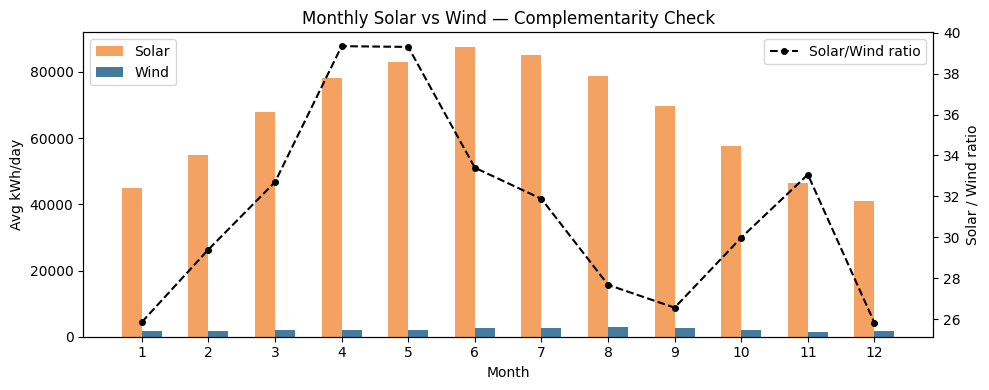

In [13]:
# 12. Solar-to-wind ratio over the year — complementarity check
"""If solar peaks in summer and wind peaks in winter, the sources
complement each other and reduce overall variability."""
monthly = energy.copy()
monthly['month'] = monthly['day'].dt.month
monthly_avg = monthly.groupby('month')[['total_solar_kwh', 'total_wind_kwh']].mean()

fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()

ax1.bar(monthly_avg.index - 0.15, monthly_avg['total_solar_kwh'], width=0.3,
        color='#f4a261', label='Solar')
ax1.bar(monthly_avg.index + 0.15, monthly_avg['total_wind_kwh'], width=0.3,
        color='#457b9d', label='Wind')
ax1.set_ylabel('Avg kWh/day')
ax1.set_xlabel('Month')
ax1.set_xticks(range(1, 13))
ax1.legend(loc='upper left')

ratio = monthly_avg['total_solar_kwh'] / monthly_avg['total_wind_kwh']
ax2.plot(monthly_avg.index, ratio, 'k--o', markersize=4, label='Solar/Wind ratio')
ax2.set_ylabel('Solar / Wind ratio')
ax2.legend(loc='upper right')

ax1.set_title('Monthly Solar vs Wind — Complementarity Check')
fig.tight_layout()
plt.show()